In [642]:
import os, sys, json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchvision

import bfio
from bfio import BioWriter, BioReader

base_dir = "/home/vihanimm/SegmentationModels/SMP_Pipeline"
polus_dir = f"{base_dir}/polus-plugins/segmentation/polus-smp-training-plugin/"
sys.path.append(polus_dir)

from src.utils import options



In [643]:
im_cell_dir = "/home/vihanimm/Data/tissuenet/ometif_data/cell/test/image"
gt_binary_cell_dir = "/home/vihanimm/Data/tissuenet/ometif_data/cell/test/groundtruth_centerbinary_2pixelsmaller"
gt_label_cell_dir  = "/home/vihanimm/Data/tissuenet/ometif_data/cell/test/groundtruth"

im_nuclear_dir = "/home/vihanimm/Data/tissuenet/ometif_data/nuclear/test/image"
gt_binary_nuclear_dir = "/home/vihanimm/Data/tissuenet/ometif_data/nuclear/test/groundtruth_centerbinary_2pixelsmaller"
gt_label_nuclear_dir  = "/home/vihanimm/Data/tissuenet/ometif_data/nuclear/test/groundtruth"

pr_basedir = "/home/vihanimm/SegmentationModels/SMP_Pipeline/cytoplasm_models_testoutputs"

In [644]:
base_cytomodel_dir = "/home/vihanimm/SegmentationModels/SMP_Pipeline/cytoplasm_models"
base_nucmodel_dir  = "/home/vihanimm/SegmentationModels/SMP_Pipeline/nuclear_models"

bestcyto_celleval_modelname  = "UnetPlusPlus-MCCLoss-vgg16-random-Adam"
bestcyto_pixeleval_modelname = "UnetPlusPlus-MCCLoss-efficientnet-b1-imagenet-Adam"


bestcyto_celleval_modelpath  = f"{base_cytomodel_dir}/{bestcyto_celleval_modelname}/checkpoint.pth"
bestcyto_pixeleval_modelpath = f"{base_cytomodel_dir}/{bestcyto_pixeleval_modelname}/checkpoint.pth"
nuc_celleval_modelpath       = f"{base_nucmodel_dir}/{bestcyto_celleval_modelname}/checkpoint.pth"
nuc_pixeleval_modelpath      = f"{base_nucmodel_dir}/{bestcyto_pixeleval_modelname}/checkpoint.pth"


In [645]:
bestcyto_celleval_model  = torch.load(bestcyto_celleval_modelpath)
bestcyto_pixeleval_model = torch.load(bestcyto_pixeleval_modelpath)

print(nuc_celleval_modelpath)
print(nuc_pixeleval_modelpath)

nuc_celleval_checkpoint       = torch.load(nuc_celleval_modelpath)
nuc_pixeleval_checkpoint      = torch.load(nuc_pixeleval_modelpath)

nuc_cell_model = options.MODELS[nuc_celleval_checkpoint["model_name"]](encoder_name=nuc_celleval_checkpoint["encoder_variant"],
                                                         encoder_weights=nuc_celleval_checkpoint["encoder_weights"],
                                                         in_channels=1,
                                                         activation="sigmoid")
nuc_cell_model.load_state_dict(nuc_celleval_checkpoint["model_state_dict"])

nuc_pixel_model = options.MODELS[nuc_pixeleval_checkpoint["model_name"]](encoder_name=nuc_pixeleval_checkpoint["encoder_variant"],
                                                         encoder_weights=nuc_pixeleval_checkpoint["encoder_weights"],
                                                         in_channels=1,
                                                         activation="sigmoid")
nuc_pixel_model.load_state_dict(nuc_pixeleval_checkpoint["model_state_dict"])

/home/vihanimm/SegmentationModels/SMP_Pipeline/nuclear_models/UnetPlusPlus-MCCLoss-vgg16-random-Adam/checkpoint.pth
/home/vihanimm/SegmentationModels/SMP_Pipeline/nuclear_models/UnetPlusPlus-MCCLoss-efficientnet-b1-imagenet-Adam/checkpoint.pth


<All keys matched successfully>

In [646]:
pr_cell_model_dir  =  f"{pr_basedir}/{bestcyto_celleval_modelname}"
pr_pixel_model_dir =  f"{pr_basedir}/{bestcyto_pixeleval_modelname}"

In [647]:
pr_cell_model_binary_dir = os.path.join(pr_cell_model_dir, "predictions")
pr_cell_model_label_dir  = os.path.join(pr_cell_model_dir, "ftl")
pr_cell_model_pixelresultpath = f"{pr_cell_model_dir}/pixeleval/result.csv"
pr_cell_model_cellresultpath  = f"{pr_cell_model_dir}/celleval/result.csv"

pr_pixel_model_binary_dir = os.path.join(pr_pixel_model_dir, "predictions")
pr_pixel_model_label_dir  = os.path.join(pr_pixel_model_dir, "ftl")
pr_pixel_model_pixelresultpath = f"{pr_pixel_model_dir}/pixeleval/result.csv"
pr_pixel_model_cellresultpath  = f"{pr_pixel_model_dir}/celleval/result.csv"

In [648]:
pr_cell_model_pixelresultdf = pd.read_csv(pr_cell_model_pixelresultpath)
pr_cell_model_cellresultdf  = pd.read_csv(pr_cell_model_cellresultpath)

pr_pixel_model_pixelresultdf = pd.read_csv(pr_pixel_model_pixelresultpath)
pr_pixel_model_cellresultdf =  pd.read_csv(pr_pixel_model_cellresultpath)

In [649]:
ex_num = 128
example_cell_name = f"cell_test_{ex_num}.ome.tif"
example_pixel_name = f"nuclear_test_{ex_num}.ome.tif"

In [650]:
pr_cellmodel_pixelFscore = pr_cell_model_pixelresultdf.loc[pr_cell_model_pixelresultdf["Image_Name"] == example_cell_name]["F-Scores (weighted) "]
pr_cellmodel_cellFscore = pr_cell_model_cellresultdf.loc[pr_cell_model_cellresultdf["Image_Name"] == example_cell_name]["F-Scores (weighted) "]
pr_pixelmodel_pixelFscore = pr_pixel_model_pixelresultdf.loc[pr_pixel_model_pixelresultdf["Image_Name"] == example_cell_name]["F-Scores (weighted) "]
pr_pixelmodel_cellFscore  = pr_pixel_model_cellresultdf.loc[pr_pixel_model_cellresultdf["Image_Name"] == example_cell_name]["F-Scores (weighted) "]

In [651]:
img_cell_examplepath = os.path.join(im_cell_dir, example_cell_name)
gt_binary_cell_examplepath = os.path.join(gt_binary_cell_dir, example_cell_name)
gt_label_cell_examplepath  = os.path.join(gt_label_cell_dir, example_cell_name)

img_nuclear_examplepath = os.path.join(im_nuclear_dir, example_pixel_name)
gt_binary_nuclear_examplepath = os.path.join(gt_binary_nuclear_dir, example_pixel_name)
gt_label_nuclear_examplepath  = os.path.join(gt_label_nuclear_dir, example_pixel_name)

pr_cell_model_binary_examplepath = os.path.join(pr_cell_model_binary_dir, example_cell_name)
pr_cell_model_label_examplepath  = os.path.join(pr_cell_model_label_dir, example_cell_name)

pr_pixel_model_binary_examplepath = os.path.join(pr_pixel_model_binary_dir, example_cell_name)
pr_pixel_model_label_examplepath  = os.path.join(pr_pixel_model_label_dir, example_cell_name)

In [652]:
with BioReader(img_cell_examplepath, backend="python") as img_cell_br:
    img_cell_arr = img_cell_br[:]
with BioReader(gt_binary_cell_examplepath, backend="python") as gt_binary_cell_br:
    gt_binary_cell_arr = gt_binary_cell_br[:]
with BioReader(gt_label_cell_examplepath, backend="python") as gt_label_cell_br:
    gt_label_cell_arr = gt_label_cell_br[:]

with BioReader(img_nuclear_examplepath, backend="python") as img_nuclear_br:
    img_nuclear_arr = img_nuclear_br[:]
with BioReader(gt_binary_nuclear_examplepath, backend="python") as gt_binary_nuclear_br:
    gt_binary_nuclear_arr = gt_binary_nuclear_br[:]
with BioReader(gt_label_nuclear_examplepath, backend="python") as gt_label_nuclear_br:
    gt_label_nuclear_arr = gt_label_nuclear_br[:]

with BioReader(pr_cell_model_binary_examplepath, backend="python") as pr_cell_model_binary_br:
    pr_cell_model_binary_arr = pr_cell_model_binary_br[:]
with BioReader(pr_cell_model_label_examplepath, backend="python") as pr_cell_model_label_br:
    pr_cell_model_label_arr = pr_cell_model_label_br[:]
with BioReader(pr_pixel_model_binary_examplepath, backend="python") as pr_pixel_model_binary_br:
    pr_pixel_model_binary_arr = pr_pixel_model_binary_br[:]
with BioReader(pr_pixel_model_label_examplepath, backend="python") as pr_pixel_model_label_br:
    pr_pixel_model_label_arr  = pr_pixel_model_label_br[:]

In [653]:
tensor_img = torch.tensor(img_nuclear_arr[None, None, ...])
print(tensor_img.shape)

torch.Size([1, 1, 256, 256])


In [654]:
nuc_cell_output = nuc_cell_model(tensor_img).detach().squeeze().numpy().astype(np.uint8)
nuc_pixel_output = nuc_pixel_model(tensor_img).detach().squeeze().numpy().astype(np.uint8)

nuc_cell_output[nuc_cell_output >= 0.5] = 255
nuc_cell_output[nuc_cell_output < .5] = 0

nuc_pixel_output[nuc_pixel_output >= 0.5] = 255
nuc_pixel_output[nuc_pixel_output < .5] = 0

cell_mask = np.ma.masked_where(nuc_cell_output == 0, nuc_cell_output)
pixel_mask = np.ma.masked_where(nuc_pixel_output == 0, nuc_pixel_output)


In [655]:
print(np.max(img_cell_arr))
print(np.min(img_cell_arr))

1.0
0.0


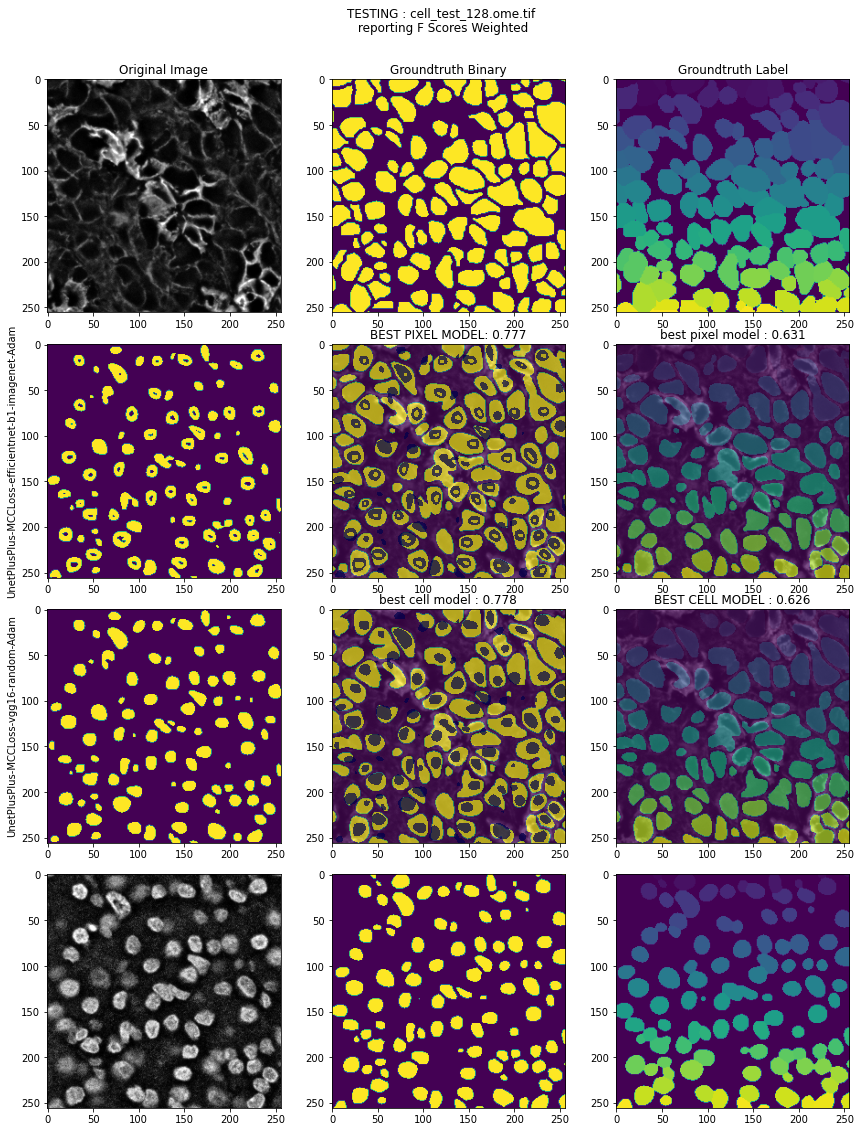

In [656]:
num_rows = 4
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*4))
plt.tight_layout(rect=[0, 0, 1, 0.93]) 
fig.suptitle(f"TESTING : {example_cell_name}\n reporting F Scores Weighted")
ax[0,0].imshow(img_cell_arr, cmap="gray")
ax[0,0].set_title("Original Image")
ax[0,1].imshow(gt_binary_cell_arr)
ax[0,1].set_title("Groundtruth Binary")
ax[0,2].imshow(gt_label_cell_arr)
ax[0,2].set_title("Groundtruth Label")

ax[1,0].set_ylabel(bestcyto_pixeleval_modelname)
ax[1,0].imshow(nuc_pixel_output)

ax[1,1].imshow(img_cell_arr, cmap="gray", alpha=.95)
ax[1,1].imshow(pr_pixel_model_binary_arr, alpha=.7)
ax[1,1].imshow(pixel_mask, cmap="seismic", alpha=0.7)
ax[1,1].set_title(f"BEST PIXEL MODEL: {pr_pixelmodel_pixelFscore.values[0]:.3f}")

ax[1,2].imshow(img_cell_arr, cmap="gray", alpha=.95)
ax[1,2].imshow(pr_pixel_model_label_arr, alpha=.7)
ax[1,2].set_title(f"best pixel model : {pr_pixelmodel_cellFscore.values[0]:.3f}")


ax[2,0].set_ylabel(bestcyto_celleval_modelname)
ax[2,0].imshow(nuc_cell_output)

ax[2,1].imshow(img_cell_arr, cmap="gray", alpha=.95)
ax[2,1].imshow(pr_cell_model_binary_arr, alpha=.7)
ax[2,1].imshow(cell_mask, cmap="seismic", alpha=0.7)
ax[2,1].set_title(f"best cell model : {pr_cellmodel_pixelFscore.values[0]:.3f}")

ax[2,2].imshow(img_cell_arr, cmap="gray", alpha=.95)
ax[2,2].imshow(pr_cell_model_label_arr, alpha=.7)
ax[2,2].set_title(f"BEST CELL MODEL : {pr_cellmodel_cellFscore.values[0]:.3f}")


ax[-1, 0].imshow(img_nuclear_arr, cmap="gray")
ax[-1, 1].imshow(gt_binary_nuclear_arr)
ax[-1, 2].imshow(gt_label_nuclear_arr)

plt.savefig(f"zz/{example_cell_name}.jpeg")
